# Experiment 11-1

A rerun and extension of `experiment-11.ipynb` that examines the swarm in Environment 2 as well as Environment 1.

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [2]:
network_file_1 = "networks/Environment1.inp"
network_file_2 = "networks/Environment2.inp"
network_file_3 = "networks/Environment3.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Environment1: ", env1_start_pool)
print("Number of Start Nodes - Environment1: ", len(env1_start_pool))
print("Number of Nodes - Environment1: ", env1.graph_num_nodes)
print("Number of Links - Environment1: ", env1.graph_num_links)

print("Start Pool - Environment2: ", env2_start_pool)
print("Number of Start Nodes - Environment2: ", len(env2_start_pool))
print("Number of Nodes - Environment2: ", env2.graph_num_nodes)
print("Number of Links - Environment2: ", env2.graph_num_links)

print("Start Pool - Environment3: ", env3_start_pool)
print("Number of Start Nodes - Environment3: ", len(env3_start_pool))
print("Number of Nodes - Environment3: ", env3.graph_num_nodes)
print("Number of Links - Environment3: ", env3.graph_num_links)

Start Pool - Environment1:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Environment1:  16
Number of Nodes - Environment1:  97
Number of Links - Environment1:  119
Start Pool - Environment2:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-045

In [3]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)

    root_path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting No Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=False, start_positions=[node], filepath=path)
            simulations_1.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns, run_until_complete=True, metric='pct_links_explored')
    yield simulations_1
    
    root_path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Naive Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_2.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns, run_until_complete=True, metric='pct_links_explored')
    yield simulations_2
    
    root_path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Mean Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_3.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns, run_until_complete=True, metric='pct_links_explored')
    yield simulations_3
    
    root_path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for number in num_agents:
        path = f'{root_path}/{number}_agents'
        for node in start_nodes:
            print(f"Starting Informed Median Swarm Simulation from Start Node: {node}; {number} agents")
            sim = Simulation(env, number, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
            simulations_4.append((node, number, sim.path_to_results_directory))
            sim.run(max_turns=max_turns, run_until_complete=True, metric='pct_links_explored')
    yield simulations_4

In [4]:
swarm_types = ['no-swarm', 'naive', 'informed-mean', 'informed-median']
fig_path = 'notable-results/Figures/Experiment-11-1'

## Simulations

The simulations will run the simulations until 100% of the network in explored or until {x} turns have elapsed. The swarm size will be varied from 10 to 100 in steps of 10. The starting positions of the swarm will be cycled according to the first fifteen starting positions in the pool of starting positions.

### Simulation 1 - Environment 1

In [5]:
start_nodes = env1_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 500
filepath = "notable-results/Experiment-11-1/Env1"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [6]:
simulations_11_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

In [7]:
no_swarm_env1 = next(simulations_11_1)

Starting Simulation Batch -  notable-results/Experiment-11-1/Env1
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  500
Starting No Swarm Simulation from Start Node: 15; 10 agents
Starting No Swarm Simulation from Start Node: 35; 10 agents
Starting No Swarm Simulation from Start Node: 131; 10 agents
Starting No Swarm Simulation from Start Node: 166; 10 agents
Starting No Swarm Simulation from Start Node: 167; 10 agents
Starting No Swarm Simulation from Start Node: 203; 10 agents
Starting No Swarm Simulation from Start Node: 219; 10 agents
Starting No Swarm Simulation from Start Node: 225; 10 agents
Starting No Swarm Simulation from Start Node: 231; 10 agents
Starting No Swarm Simulation from Start Node: 243; 10 agents
Starting No Swarm Simulation from Start Node: 253; 10 agents
Starting No Swarm Simulation from Start Node: River; 10 agents
Starting

In [8]:
naive_swarm_env1 = next(simulations_11_1)

Starting Naive Swarm Simulation from Start Node: 15; 10 agents
Starting Naive Swarm Simulation from Start Node: 35; 10 agents
Starting Naive Swarm Simulation from Start Node: 131; 10 agents
Starting Naive Swarm Simulation from Start Node: 166; 10 agents
Starting Naive Swarm Simulation from Start Node: 167; 10 agents
Starting Naive Swarm Simulation from Start Node: 203; 10 agents
Starting Naive Swarm Simulation from Start Node: 219; 10 agents
Starting Naive Swarm Simulation from Start Node: 225; 10 agents
Starting Naive Swarm Simulation from Start Node: 231; 10 agents
Starting Naive Swarm Simulation from Start Node: 243; 10 agents
Starting Naive Swarm Simulation from Start Node: 253; 10 agents
Starting Naive Swarm Simulation from Start Node: River; 10 agents
Starting Naive Swarm Simulation from Start Node: Lake; 10 agents
Starting Naive Swarm Simulation from Start Node: 1; 10 agents
Starting Naive Swarm Simulation from Start Node: 2; 10 agents
Starting Naive Swarm Simulation from Start 

In [9]:
informed_mean_swarm_env1 = next(simulations_11_1)

Starting Informed Mean Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: River; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: 1; 10 

In [10]:
informed_median_swarm_env1 = next(simulations_11_1)

Starting Informed Median Swarm Simulation from Start Node: 15; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 35; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 131; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 166; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 167; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 203; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 219; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 225; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 231; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 243; 10 agents
Starting Informed Median Swarm Simulation from Start Node: 253; 10 agents
Starting Informed Median Swarm Simulation from Start Node: River; 10 agents
Starting Informed Median Swarm Simulation from Start Node: Lake; 10 agents
Starting Informed Median Swarm Simula

### Simulation 2 - Environment 2

In [11]:
start_nodes = env2_start_pool[:15]
num_agents = [i for i in range(10, 110, 10)]
max_turns = 500
filepath = "notable-results/Experiment-11-1/Env2"

print("Start Nodes: ", start_nodes)
print("Number of Agents: ", num_agents)

Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [12]:
# simulations_11_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)

In [13]:
# no_swarm_env2 = next(simulations_11_2)

Starting Simulation Batch -  notable-results/Experiment-11-1/Env2
Number of Agents:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Max Turns:  500
Starting No Swarm Simulation from Start Node: A2148; 10 agents
Starting No Swarm Simulation from Start Node: A3007; 10 agents
Starting No Swarm Simulation from Start Node: A3018; 10 agents
Starting No Swarm Simulation from Start Node: A5065; 10 agents
Starting No Swarm Simulation from Start Node: A5071; 10 agents
Starting No Swarm Simulation from Start Node: A5078; 10 agents
Starting No Swarm Simulation from Start Node: A5153; 10 agents
Starting No Swarm Simulation from Start Node: A5169; 10 agents
Starting No Swarm Simulation from Start Node: A5174; 10 agents
Starting No Swarm Simulation from Start Node: A5175; 10 agents
Starting No Swarm Simulation from Start Node: A5178; 10 agents
Starting No Sw

In [14]:
# naive_swarm_env2 = next(simulations_11_2)

Starting Naive Swarm Simulation from Start Node: A2148; 10 agents
Starting Naive Swarm Simulation from Start Node: A3007; 10 agents
Starting Naive Swarm Simulation from Start Node: A3018; 10 agents
Starting Naive Swarm Simulation from Start Node: A5065; 10 agents
Starting Naive Swarm Simulation from Start Node: A5071; 10 agents
Starting Naive Swarm Simulation from Start Node: A5078; 10 agents
Starting Naive Swarm Simulation from Start Node: A5153; 10 agents
Starting Naive Swarm Simulation from Start Node: A5169; 10 agents
Starting Naive Swarm Simulation from Start Node: A5174; 10 agents
Starting Naive Swarm Simulation from Start Node: A5175; 10 agents
Starting Naive Swarm Simulation from Start Node: A5178; 10 agents
Starting Naive Swarm Simulation from Start Node: A5183; 10 agents
Starting Naive Swarm Simulation from Start Node: A5184; 10 agents
Starting Naive Swarm Simulation from Start Node: A5185; 10 agents
Starting Naive Swarm Simulation from Start Node: A5187; 10 agents
Starting N

In [15]:
# informed_mean_swarm_env2 = next(simulations_11_2)

Starting Informed Mean Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Mean Swarm Simulation from Start Node: A5184; 10 agents
Starting Informed Mean Swarm Simulatio

In [16]:
# informed_median_swarm_env2 = next(simulations_11_2)

Starting Informed Median Swarm Simulation from Start Node: A2148; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3007; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A3018; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5065; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5071; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5078; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5153; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5169; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5174; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5175; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5178; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5183; 10 agents
Starting Informed Median Swarm Simulation from Start Node: A5184; 10 agents
Starting Inf

## Analysis

In [17]:
from typing import List

# Read the results from the simulations
def read_results(simulations, swarm_type) -> List[pd.DataFrame]:
    results = []
    for sim in simulations:
        start_node, num_agents, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        df['num_agents'] = num_agents
        df.num_agents = num_agents
        df['swarm_type'] = swarm_type
        df.swarm_type = swarm_type
        results.append(df)
    return results

In [18]:
# Method to get the turns at the end of each simulation
def get_turn(df):
    return df.turn.max()

### Analysis 1 - Environment 1

In [19]:
no_res_env1 = read_results(no_swarm_env1, 'no-swarm')
naive_res_env1 = read_results(naive_swarm_env1, 'naive')
imean_res_env1 = read_results(informed_mean_swarm_env1, 'informed-mean')
imed_res_env1 = read_results(informed_median_swarm_env1, 'informed-median')
results_env1 = pd.concat([pd.concat(no_res_env1), pd.concat(naive_res_env1), pd.concat(imean_res_env1), pd.concat(imed_res_env1)])

In [20]:
# Make a dataframe with the number of turns at the end of each simulation, the start node, the number of agents, and the swarm type
turns_env1 = results_env1.groupby(['start_node', 'num_agents', 'swarm_type']).apply(get_turn).reset_index()
turns_env1.columns = ['start_node', 'num_agents', 'swarm_type', 'turns']
turns_env1

,start_node,num_agents,swarm_type,turns
0,1,10,informed-mean,375
1,1,10,informed-median,375
2,1,10,naive,153
3,1,10,no-swarm,499
4,1,20,informed-mean,86
...,...,...,...,...
595,River,90,no-swarm,499
596,River,100,informed-mean,81
597,River,100,informed-median,81
598,River,100,naive,135


### Graphs 1 - Environment 1

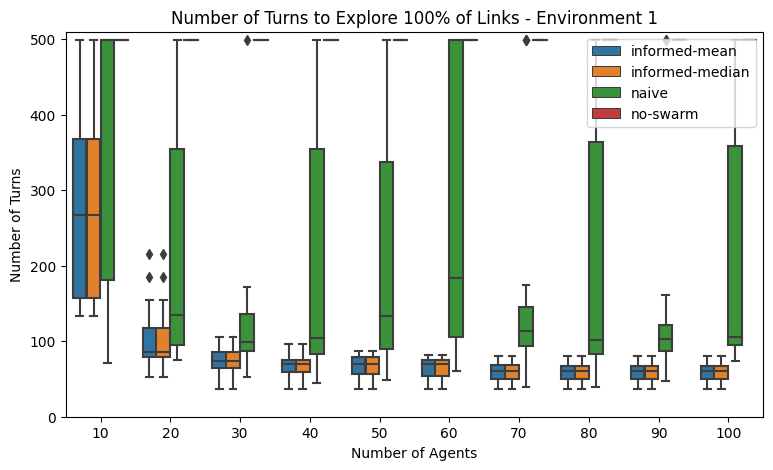

In [21]:
# Box plot with the number of turns to explore 100% of the links/max turns for each swarm type at each swarm size
fig, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(x='num_agents', y='turns', hue='swarm_type', data=turns_env1, ax=ax)
ax.set_title("Number of Turns to Explore 100% of Links - Environment 1")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Number of Turns")
ax.set_ylim(0, 510)
ax.legend(loc='upper right')
plt.savefig(f"{fig_path}/pct_lim_swarm_num_env1.png", dpi=300)
plt.savefig(f"{fig_path}/pct_lim_swarm_num_env1.eps", dpi=300)


### Analysis 2 - Environment 2

In [22]:
no_res_env2 = read_results(no_swarm_env2, 'no-swarm')
naive_res_env2 = read_results(naive_swarm_env2, 'naive')
imean_res_env2 = read_results(informed_mean_swarm_env2, 'informed-mean')
imed_res_env2 = read_results(informed_median_swarm_env2, 'informed-median')
results_env2 = pd.concat([pd.concat(no_res_env2), pd.concat(naive_res_env2), pd.concat(imean_res_env2), pd.concat(imed_res_env2)])

In [23]:
# Make a dataframe with the number of turns at the end of each simulation, the start node, the number of agents, and the swarm type
turns_env2 = results_env2.groupby(['start_node', 'num_agents', 'swarm_type']).apply(get_turn).reset_index()
turns_env2.columns = ['start_node', 'num_agents', 'swarm_type', 'turns']
turns_env2

,start_node,num_agents,swarm_type,turns
0,A2148,10,informed-mean,499
1,A2148,10,informed-median,499
2,A2148,10,naive,499
3,A2148,10,no-swarm,499
4,A2148,20,informed-mean,499
...,...,...,...,...
595,A5187,90,no-swarm,499
596,A5187,100,informed-mean,499
597,A5187,100,informed-median,499
598,A5187,100,naive,499


### Graphs 2 - Environment 2

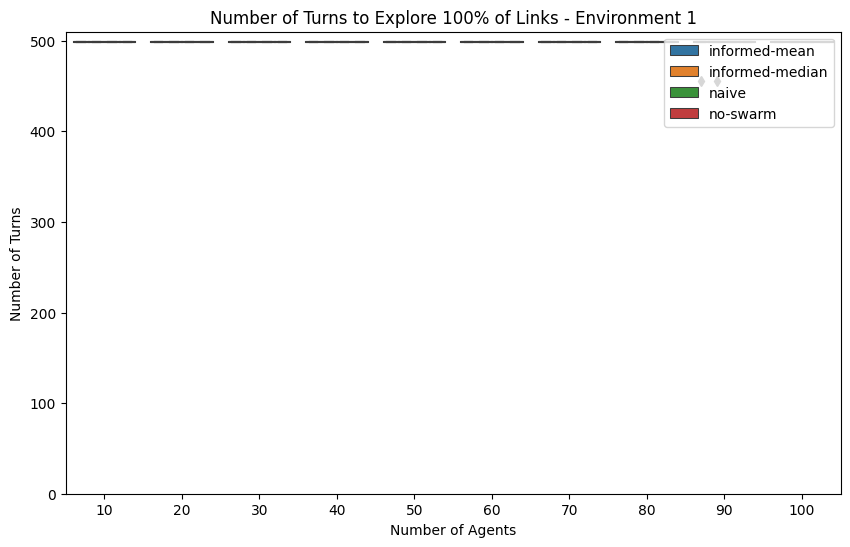

In [24]:
# Box plot with the number of turns to explore 100% of the links/max turns for each swarm type at each swarm size
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='num_agents', y='turns', hue='swarm_type', data=turns_env2, ax=ax)
ax.set_title("Number of Turns to Explore 100% of Links - Environment 1")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Number of Turns")
ax.set_ylim(0, 510)
ax.legend(loc='upper right')
plt.savefig(f"{fig_path}/pct_lim_swarm_num_env2.png", dpi=300)
plt.savefig(f"{fig_path}/pct_lim_swarm_num_env2.eps", dpi=300)
